# **Taller de Python**
## Profesor: Juan S. Moreno y Julian E. Chitiva B.
## Clase 14: Automatización de Reportes con Excel

Esta clase haremos uso extensivo de <a href="https://xlsxwriter.readthedocs.io/working_with_pandas.html">XlsxWriter</a>.

Esta es una herramienta que permite crear archivos de excel a partir de objetos de python. Adicionalmente permite añadir formato (y muchas cosas más) a las celdas.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import os

1. Cargue la heart del `sm.datasets`. Explore la descripción y la nota.

In [2]:
print(sm.datasets.heart.NOTE)
print(sm.datasets.heart.DESCRLONG)
datos = sm.datasets.heart.load_pandas().data
datos.head()

::

    Number of Observations - 69

    Number of Variables - 3

    Variable name definitions::
        death - Days after surgery until death
        age - age at the time of surgery
        censored - indicates if an observation is censored.  1 is uncensored

This data contains the survival time after receiving a heart transplant, the age of the patient and whether or not the survival time was censored.



,survival,censors,age
0,15.0,1.0,54.3
1,3.0,1.0,40.4
2,624.0,1.0,51.0
3,46.0,1.0,42.5
4,127.0,1.0,48.0


2. Calcule la matriz de correlación de la base de datos. 
- Importe la funcion pearsonr de `scipy.stats`, explore su funcionmiento.
- Calcule la correlacion usando esa funcion (Primera compontente).
- Calcule la significancia p-value usando esa funcion (Segunda compontente).

In [3]:
from scipy.stats import pearsonr

In [4]:
rho = datos.corr(method=lambda x, y: pearsonr(x, y)[0])
rho

,survival,censors,age
survival,1.000000,-0.461949,-0.129550
censors,-0.461949,1.000000,0.365187
age,-0.129550,0.365187,1.000000


In [5]:
pval = datos.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
pval

,survival,censors,age
survival,0.000000,0.000065,0.288716
censors,0.000065,0.000000,0.002033
age,0.288716,0.002033,0.000000


3. Use el paquete seaborn para crear un mapa de calor de estas correlaciones donde el texto sea el valor de la correlacion donde solo se muestren aquellos valores significativos.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
texto = rho[pval<0.05].round(2)
texto[np.isnan(texto)]=""

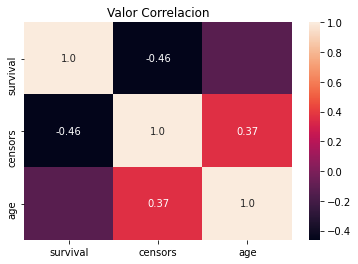

In [8]:
sns.heatmap(rho, annot=texto, fmt='')
plt.title('Valor Correlacion')
plt.savefig('corr.png', bbox_inches = 'tight' )
plt.show()

4. Cree un ExcelWriter. Esta es una funcion de Pandas que sirve para escribir archivos de excel con más flexibilidad que el `.to_excel`.
    - Use `xlsxwriter` como engine.
    - Explore que tiene el `writer` por dentro.


In [9]:
## Crear un ExcelWriter
writer = pd.ExcelWriter('correlaciones.xlsx',
                        engine='xlsxwriter')

5. Pruebe guardar el archivo usando `writer.save()`, este debe ser un archivo vacío.

writer.save()

6. Excel funciona con libros (*Workbook* o *book*). Extraigalo del writer y explore que tiene por dentro.

In [10]:
workbook  = writer.book

7. Agregue los resultados de los coeficientes de correlacion.
    - Hoja Resultados.
    - Ponga los encabezados e indices.
    - La Tabla debe iniciar en la fila 3 y columna 1.

In [11]:
rho.to_excel(writer, 
             sheet_name='Resultados',
             header=True,
             index=True, 
             startrow=3-1,
             startcol=1-1)

. A este workbook se le pueden añadir formatos. Estos formatos los usaremos para darle formato a las celdas. 

Cree un formato llamado Encabezado
+ Negrilla
+ Text_wrap
+ Tamaño 18
+ letra color ```#ffffff```
+ alineacion centrado 
+ fondo color ```#153261```
+ todos los bordes

In [12]:
encabezado = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'font_size':18,
    'font_color':'#ffffff',
    'align': 'center',
    'valign': 'vcenter',
    'fg_color': '#153261',
    'border': 1})

8. Extraiga la hoja de **Resultados** en el writer usando la funcion `sheets['nombrehoja']`


In [13]:
hoja = writer.sheets['Resultados']

9. Haga un "combinar y centrar":
    - Combine las celdas A1:M1.
    - Escriba "Resultados Correlación".
    - Use el formato encabezado.

In [14]:
hoja.merge_range('A1:M1', 'Resultados Correlación', encabezado)

10. Incluya la imagen del mapa de calor que guardo antes. 
    - La imagen debe ir en la fila 3 columna 6

In [15]:
hoja.insert_image(3-1, 6-1, 'corr.png')

11. Cree un dataframe con:
    - primera columna: 100 numeros de -10 a 10 (use `np.linspace`).
    - segunda columna: 100 numeros aleatorios N(0,9).

In [16]:
n = 100
datos = pd.DataFrame({
    'primera' : np.linspace(-10,10,n),
    'segunda' : np.random.normal(loc=0, scale=9,size=100)
})

12. Agrege estos datos desde la fila 2 sin encabezado ni indice

In [17]:
datos.to_excel(writer, 
               sheet_name='Formulas',
               header=False,
               index=False,
               startrow=2-1)

13. Extraiga la hoja "Formulas" 

In [18]:
hoja = writer.sheets['Formulas']

14. Escriba en las celdas lo siguiente con formato encabezado:
    - A1: ```'Entero' u"\U0001F610"```. 
    - B1: ```'Normal' u"\U0001F600"```.
    - C1: ```'Formula' u"\U0001F62E"```.

In [19]:
hoja.write(0,0,'Entero'+u"\U0001F62C", encabezado)
hoja.write(0,1,'Normal'+u"\U0001F600", encabezado)
hoja.write(0,2,'Formula'+u"\U0001F62E", encabezado)

0

15. Ajuste el ancho de estas columnas a 18.

In [20]:
hoja.set_column('A:C', 18)

0

16. En la columna C de esta hoja defina una formula que sea 10*A+B. 

Pista: Ojo con la el número de la fila en la formula. 


In [21]:
filas = range(1,n)
for x in filas:
    hoja.write_formula(x,2, '=10*A'+str(x+1)+'+B'+str(x+1))

17. Cree un gráfico de dispersion en el libro con la funcion `add_chart({'type':'scatter'})`

In [22]:
chart = workbook.add_chart({'type': 'scatter'})

18. Agregue la serie de datos con un diccionario de los siguientes parametros
    - name: puntos
    - values: Formula de los valores de la columna C (Eje Y)
    - categories: Formula de los valores de la columna A (Eje X) 
    - trendline: 
        + type: linear
        + display_r_squared: True

In [23]:
chart.add_series({
    'name':'Puntos',
    'values':  '=Formulas!$C$'+str(filas[0]+1)+':$C$'+str(filas[-1]+1),
    'categories':  '=Formulas!$A$'+str(filas[0]+1)+':$A$'+str(filas[-1]+1),
    'trendline': {'type': 'linear',
                  'display_r_squared': True,
    },
})

19. Fije el titulo del gráfico con `set_title`
    - name: 'Grafio de Dispersión'

In [24]:
chart.set_title ({'name': 'Prueba de Dispersion'})

20. Explore el funcionamiento del `set_x_axis`, `set_y_axis` y `set_legend`.
Las opciones que puede explorar son:
- name
- major_gridlines
- position

In [25]:
chart.set_x_axis({'name': 'x'})
chart.set_y_axis({'name': 'y','major_gridlines':{'visible':False}})
chart.set_legend({'position': 'bottom'})

21. Inserte el grafico en la celda E5 de la hoja Formulas.

In [26]:
hoja.insert_chart('E5', chart)

22. Defina el tamaño del libro a 1500x1000 y guarde el archivo. Pista: este numero puede depender de la resolución de su pantalla.

In [27]:
# Cerrar y guardar el excel
workbook.set_size(1080,1280)
writer.save()

23. Elimine la imagen que creó si ya no la necesita

In [28]:
os.remove('corr.png')